# PyMC3: Bayesian inference that would be hard otherwise

Like the notebook [Bayesian linear regression](https://github.com/harcel/blog/blob/master/Bayesian_linear_regression.ipynb), this post shows some simple first steps into the world of Bayesian stats. If you haven't yet, you might want to go through the other notebook first.

We will again use a simple data set that is generated with a few lines of numpy. This time, a simple PyMC3 likelihood won't suffice, as we will see, and I will show you how to easily get around that issue.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import pymc3 as pm

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

print('Running on PyMC3 v{}'.format(pm.__version__))

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

Running on PyMC3 v3.9.3


## Creating a fake data set to work with

A fake, and rather un-inspiring data set is created on top of which we want to do linear regression. The data is quite suitable for that, indeed. A linear relation between x and y is created, so that after regression the recovered variables can be compared to the original ones. This time, on top of the linear relation I add "noise" that comes from the exponential distribution, which is asymmetric (only positive values and a PDF that declines exponentially). Let's have a look:

In [8]:
size = 100
true_intercept = 4
true_slope = 6

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise, only upwards from an exponential
noise = np.random.exponential(scale=3., size=size)
y = true_regression_line + noise


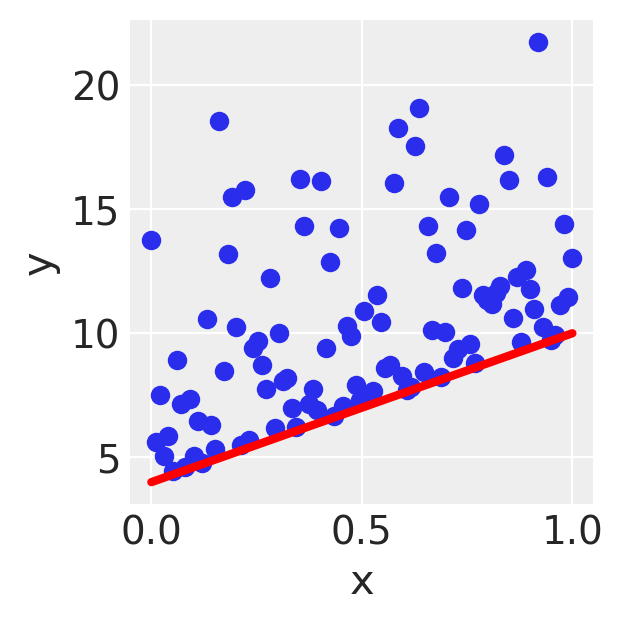

In [9]:
# Here's what it looks like
plt.figure(figsize=(3,3))
plt.scatter(x, y)
plt.plot(x, true_regression_line, color='red', linewidth=3)
plt.xlabel('x'); plt.ylabel('y');

## Bayes, but different...

We would want to take a similar approach to the linear regression in the notebook [Bayesian linear regression](https://github.com/harcel/blog/blob/master/Bayesian_linear_regression.ipynb), but we will run into an issue soon enough.

Whereas in the case of gaussian we could write the likelihood as 
```
likelihood = pm.Normal('y', mu=intercept + x_coeff * x, sigma=sigma, observed=y)
```
We basically use the linear relation that we are after as the location of the gaussian (`mu`). But.... The [implementation of the exponential distribution in PyMC3](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) has no location, it is at zero and will stay at zero! So we cant simply write something like
```
likelihood = pm.Exponential('y', loc=intercept + x_coeff * x, lam=lam, observed=y)
```
(`lam` would be the lambda parameter of the distribution, that we have to put a prior on, see below), because that `loc` parameter invented by me doesn't exist. Obviously one can get around this problem, but for the beginner it may not me immediately obvious. To me it wasn't, anyway.

#### Invent your own distribution function
You can invent your own distribution function! You can base it on a distribution function that exists and basically borrow each and every attribute and method from it, but include the functionality you need. What is crucial, is that the class has a `logp` method, as the sampler will use that. With the code below, we copy the whole exponential distrubtion class and add our own functionality.


In [10]:
# First define our new class
class shiftedExp(pm.Exponential):
    # I include the crucial named parameters here, but leave the possibility of including other (kw)args
    
    def __init__(self, lam=1., shift=0, *args, **kwargs):
        # For the init, I use the parent's init, leaving out my new custom argument
        # The parent class doesn't know about this, that's the whole point!
        super().__init__(lam=lam, *args, **kwargs)
        self.lam = lam
        self.shift = shift
    
    
    def logp(self, value):
        # I re-define the logp method by just putting in not the value, but the shifted value.
        # Luckily, that doesn't change the integral, which you should care about
        return super().logp(value-self.shift)


with pm.Model() as expreg: # model specifications in PyMC3 are wrapped in a context
    # This whole inference block is quite like before, see the other notebook if you need explanations!
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('Slope', 0, sigma=20)
    upnoise = pm.HalfNormal('Noise', sigma=12.)

    # Here is use my custom distribution function, where I can use the same trick as in the 
    # linear regression before: sample from an exponential shifted to the linear line we are after.
    likelihood = shiftedExp('y', lam=upnoise, shift=intercept+x_coeff*x, observed=y)
    
    # Inference! The posterior PDF will be sampled
    trace = pm.sample(5000, cores=2, tune=3000) 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Noise, Slope, Intercept]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 16 seconds.
There were 4508 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4802 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept  4.005  0.067   3.866    4.089      0.008    0.005      77.0   
Slope      5.950  0.119   5.709    6.186      0.010    0.007     133.0   
Noise      0.293  0.029   0.239    0.347      0.001    0.001     379.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept    77.0     129.0     111.0   1.02  
Slope       129.0     123.0     108.0   1.02  
Noise       379.0     380.0     933.0   1.01  


<Figure size 700x700 with 0 Axes>

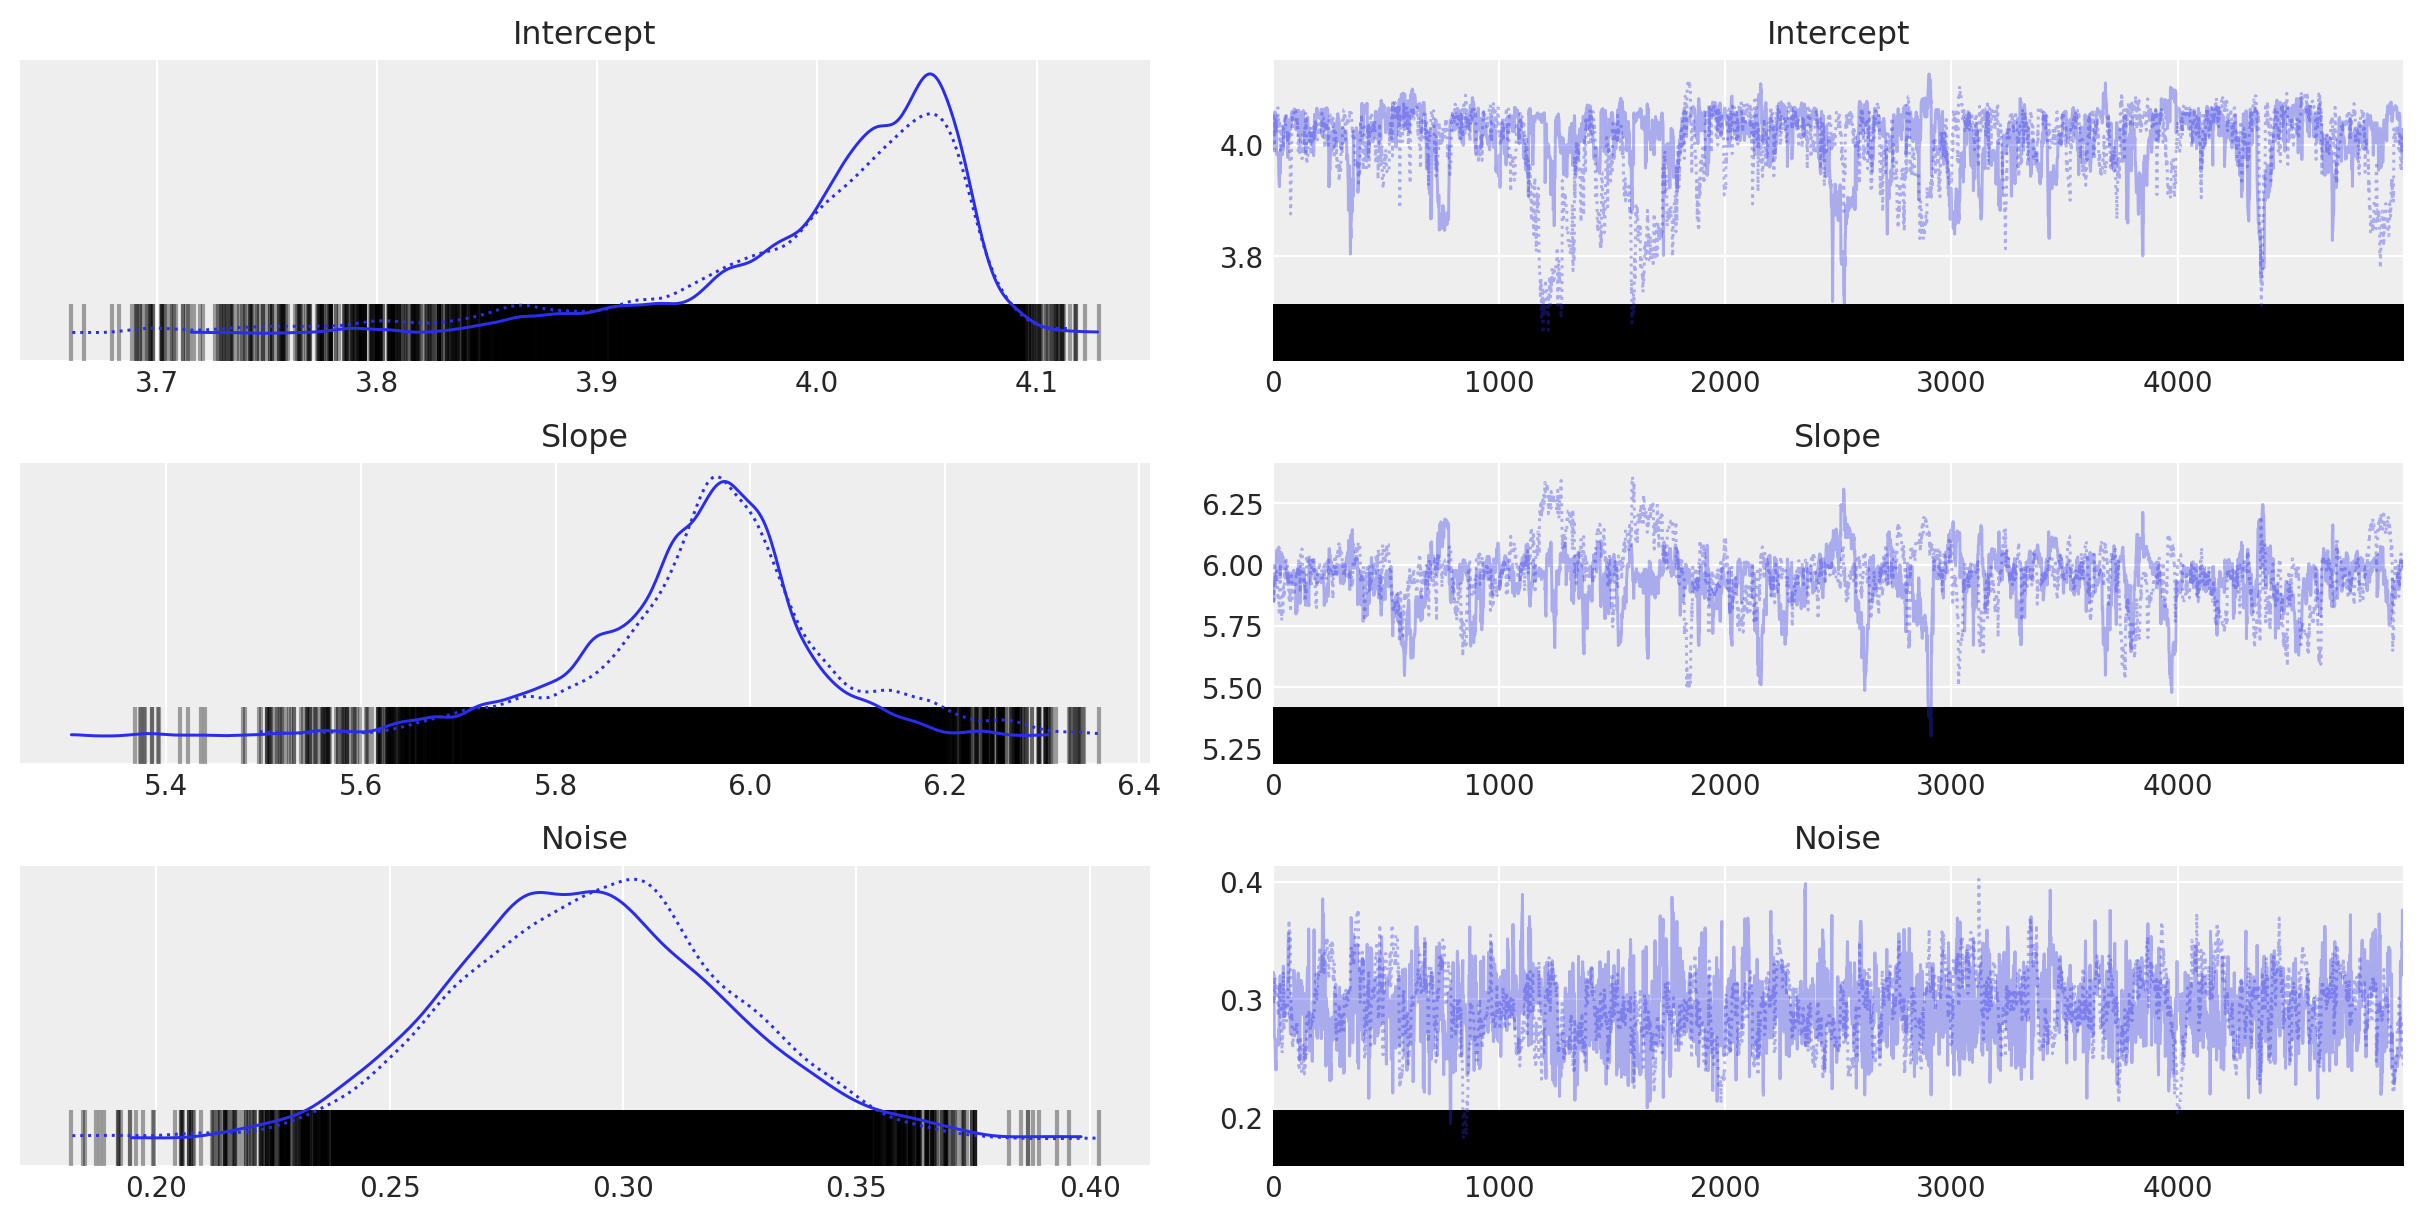

In [11]:
# After the inference we can get back into the model context and do more, like investigating results
with expreg:
    plt.figure(figsize=(7,7))
    print(pm.summary(trace)) # A summary of the results for all stochastic variables
    pm.traceplot(trace); # This comes from arviz, called by pymc3 and shows traces and marginal posterior PDFs
    

On the left, you see the marginal posterior PDFs for all stochastic variables. The two lines are for the two chains (two independent Markov Chains were used to sample the posterior). To the right you see the "traces", which describe how the value of the variables was jumping up and down while sampling. The reason to plot that trace is that you want it to be flat and fuzzy, not bending up or down, no "flat" region where it isn't varying, becasue all such things would indicate that there was an issue while sampling.

You can use samples from the posterior (points along the trace) to in fact "predict" values like you would when doing machine learning:

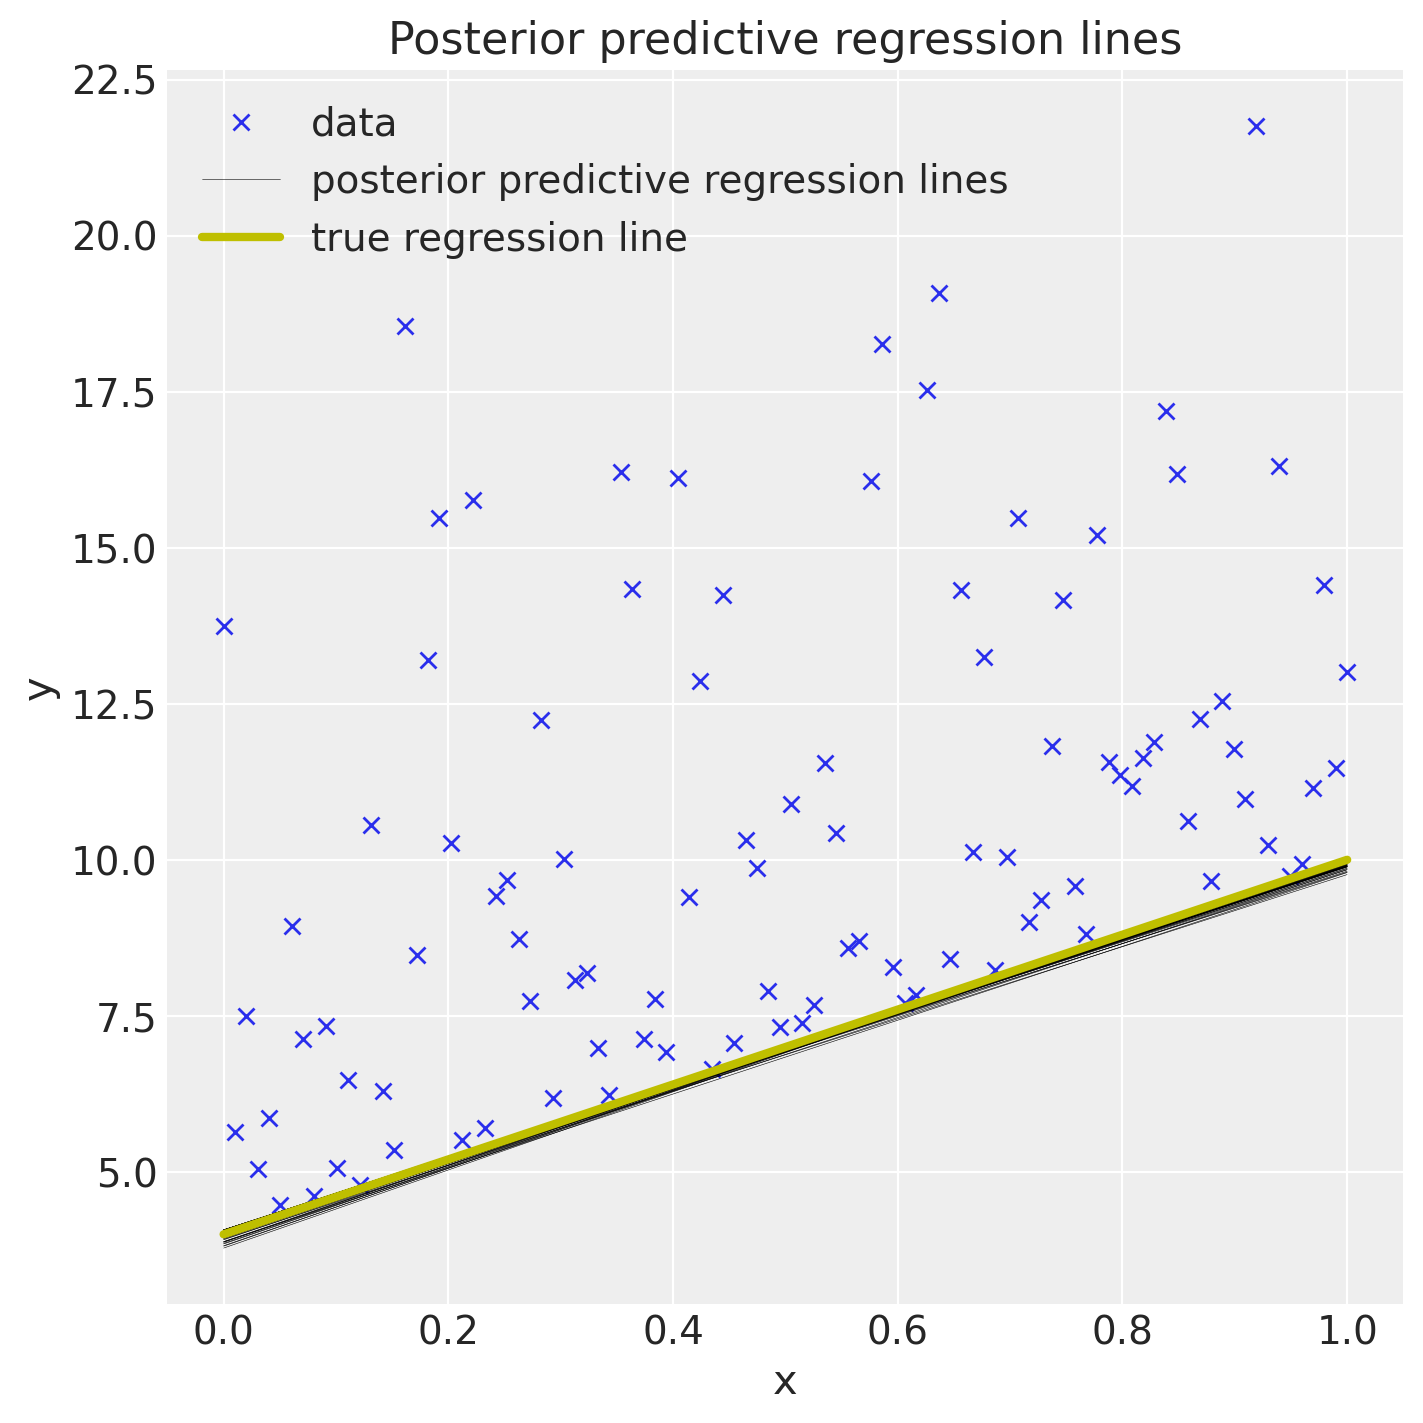

In [12]:
# We can also sample the posterior to plot a bunch of reasonable fits, according to the posterior PDF
with expreg:
    plt.figure(figsize=(7, 7))
    plt.plot(x, y, 'x', label='data')
    # Again, kindly provided by arviz, called from pymc3:
    pm.plot_posterior_predictive_glm(trace, samples=100, lm=(lambda  x, sample: sample['Intercept'] + sample['Slope'] * x),
                                  label='posterior predictive regression lines')
    plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

    plt.title('Posterior predictive regression lines')
    plt.legend(loc=0)
    plt.xlabel('x')
    plt.ylabel('y');


As you can see, this works fairly well! All regression lines basically fall on top of each other and follow the input line very well. Not too bad! So, we also know the value of the scale of our exponential distribution now. Note that numpy and PyMC3 have different, but equivalent definitions of the PDF: $\lambda \exp\{-\lambda x\} = \frac1{\beta} \exp\{-x/\beta\}$. So the noise parameter we expect to find is 1/`scale`. Compare the PyMC3 page linked above to the [numpy docs](https://docs.scipy.org/doc/numpy-1.9.2/reference/generated/numpy.random.exponential.html)!

So, let's plot the posterior probability densities:

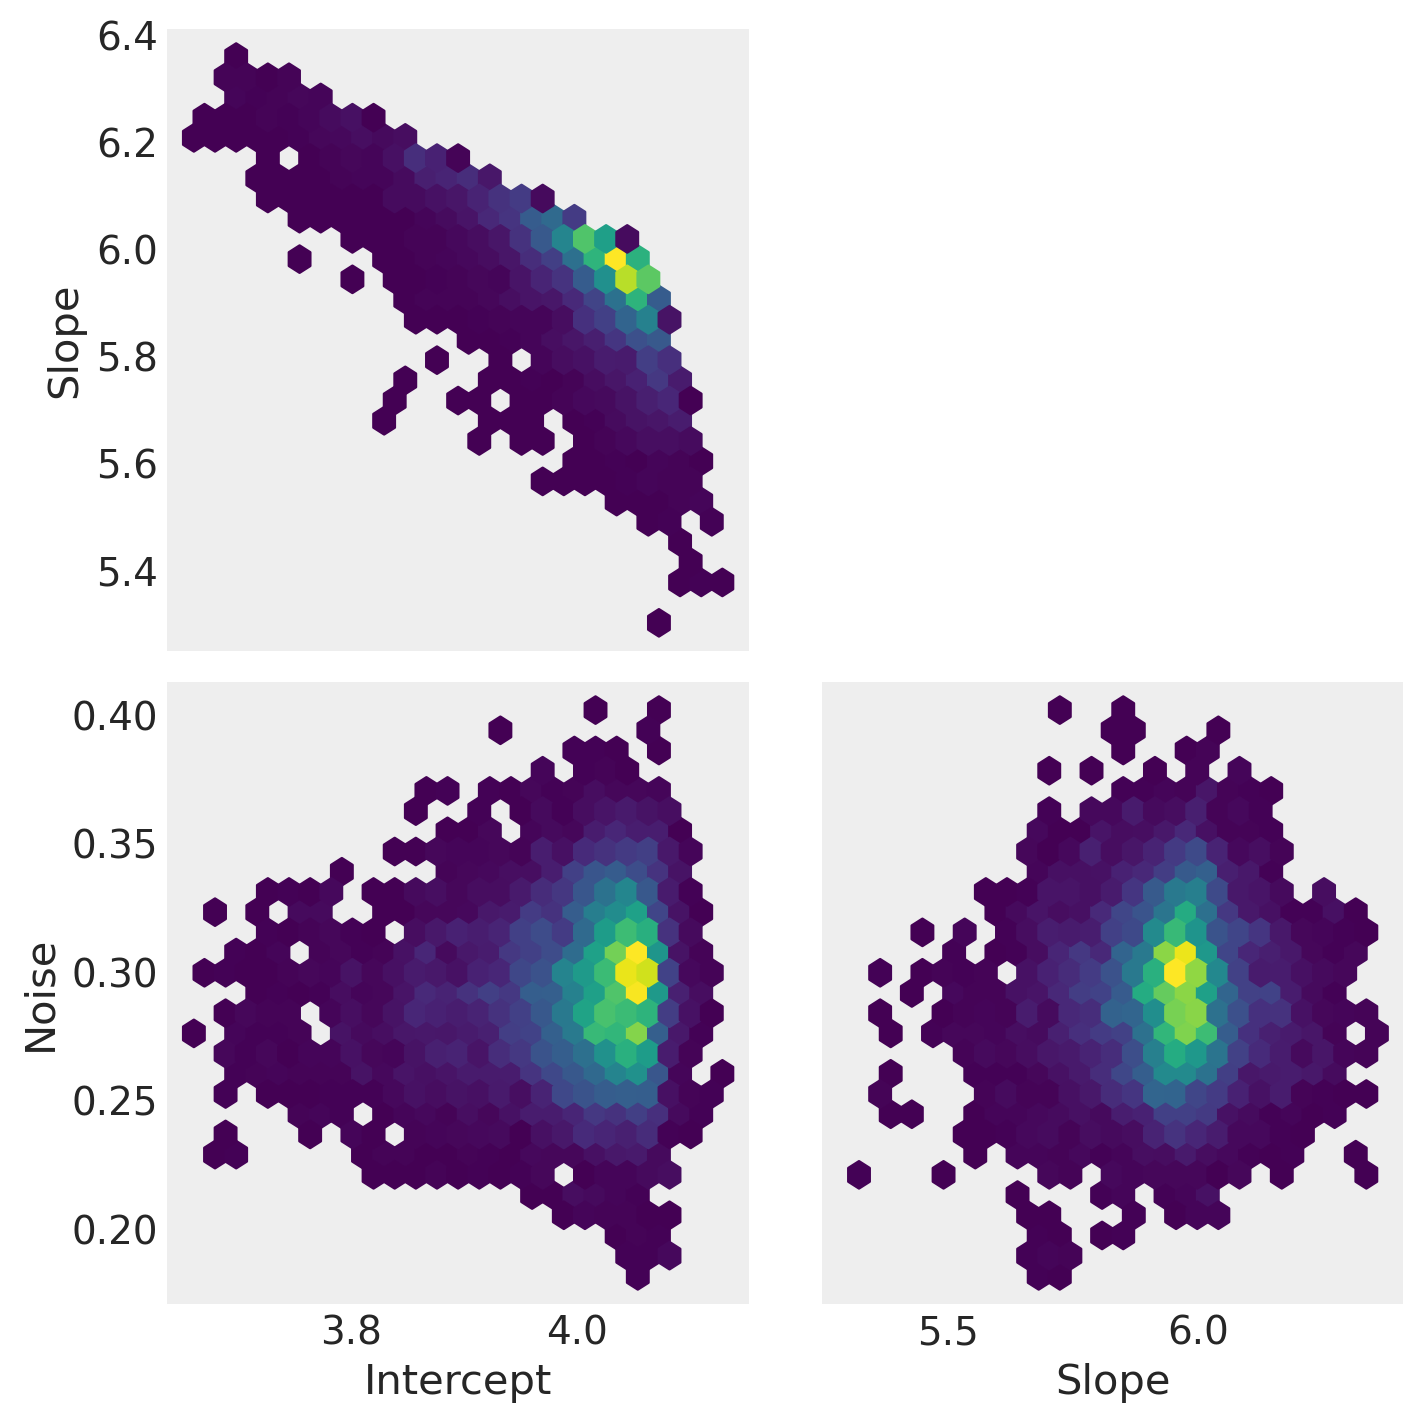

In [13]:
# You can also look at the joint PDFs of the involved stochastic variables, which gives nice insights
with expreg:
    pm.pairplot(trace, kind='hexbin', figsize=(7,7))

The top plot shows the anti-correlation we also saw in teh linear regression example. The intersting, linear looking cut-offs are caused by the exponential PDF that has zero probability density as soon as one data point would fall below the line.

I might follow up with more posts in the future, who knows... 

For now I will leave you with some great **references**:
- [A blog series](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake VanderPlas.
- [A nice PyMC3 tutorial](https://www.youtube.com/watch?v=SS_pqgFziAg) by BDFL Chris Fonnesbeck.
- [A fun podcast: Learning Bayesian Statistics](https://learnbayesstats.anvil.app/) by Alex Andorra.
- [The official PyMC3 tutorials](https://docs.pymc.io/nb_tutorials/index.html).
- [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3) by Cameron Davidson-Pilon (PyMC3 version).



*By Marcel Haas, Jan 13, 2021*

*datascience@marcelhaas.com*